In [2]:
import pandas as pd
import numpy as np
import plotnine as pn
from siuba import filter, group_by, gather, _, summarize, arrange, select, inner_join, mutate, ungroup, count

def plot_fix(wspace=0.25): 
    return pn.theme_minimal() + pn.theme(plot_background=pn.element_rect(fill="#FEF6E0", color="#FEF6E0"),  \
        strip_text = pn.element_text(  weight="bold"), subplots_adjust={'wspace':wspace}, panel_grid=pn.element_line(color="antiquewhite")) 

pd.set_option('display.max_colwidth', None)
pd.set_option("display.precision", 3)
pd.set_option('display.max_rows', 60)

In [4]:
# ml imports
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn import metrics
from sklearn.model_selection import GridSearchCV

In [9]:
relative_path = "NL_slowchat_raw_data.pickle"
df = pd.read_pickle(relative_path) >> filter(~_.Text.isna())

In [11]:
saken = "(?:denne)? ?(?:saken|skadesaken|skadesak|sak|forsikringssaken|skaden|kravet|saka)"
avsluttes = "(?:da|derfor)? ?(?:avsluttes|slettes|avslutas|avslutast|avsluttast|kanselleres|lukkes|slettes|trekkes)"
avsluttet = "(?:avsluttet|avslutta|lukket|lukka|kansellert|behandlet|ferdigbehandlet|slettet|sletta|trukket)"
avslutte = "(?:avslutte|kansellere|lukke|slette)"
avslutter = "(?:avslutter|kansellerer|lukker|sletter|trekker|trekkjer)"
avslutt = "(?:avslutt|kanseller|lukk|slett)"
jeg = "(?:jeg|vi|eg)"
min = "(?:min|våres|vår)"
dere = "(?:du|dere|gjensidige)"
forsikringen = "(?:forsikringen|forsikring)"
brukt = "(?:brukt|benyttet)"
bruker = "(?:bruker|benytter|benyttjer|benyttar)"
bruke = "(?:bruke|benytte)"
ikke = "(?:ikke|ikkje)"
noe = "(?:noe|noko)"

regexes = [
    f"koster under egenandelen",
    f"{saken} kan {avsluttes}",
    f"ønsker {jeg}? ?{ikke} (?:å)? ?{bruke} {forsikringen}",
    f"Beløpet er under egenandel",
    f"{forsikringen} blir {ikke} {brukt}",
    f"(?:Bare|berre) å {avslutte} {saken}",
    f"kostnad(?:en)? er under egenandel",
    f"Kostnaden[e] for å utbedre skaden er under egenandelen",
    f"Velger å {ikke} {bruke} (?:meg|oss) av {forsikringen}",
    f"velger å {ikke} {bruke} {forsikringen} {min} på {saken}",
    f"{jeg} tar kostnaden selv",
    f"(?:anser vi|vi anser) {saken} som {avsluttet}",
    f"{dere} kan {avslutte} {saken}",
    f"{jeg} ønsker å {avslutte} {saken}",
    f"Har tatt regningen selv",
    f"beløp ble lavere enn egenandel",
    f"for å {ikke} {bruke} {forsikringen}",
    f"uten bruk av {forsikringen}",
    f"bestemt (?:meg|oss) for å {ikke} {bruke} {forsikringen}",
    f"{jeg} {avslutter} {saken}",
    f"Kan {dere} {avslutte} {saken}",
    f"kan vel {saken} {avsluttes}",
    f"{jeg} kan {avslutte} {saken}",
    f"Da {avslutter} {jeg} {saken} her",
    f"{jeg} ser {saken} som {avsluttet}",
    f"fra {min} side er {saken} {avsluttet}",
    f"Da kan {saken} {avsluttes}",
    f"Anser {saken} som {avsluttet}",
    f"Da er {saken} {avsluttet} fra {min} side",
    f"{saken} er løst\\.",
    f"{saken} kan (?:bare)? ?{avsluttes}",
    f"{jeg} ber om (?:at)? ?(?:saken|skadesaken) {avsluttes}",
    f"(?:mindre|lavere) enn egenandelen",
    f"{dere} bare {avslutter} {saken}",
    f"{saken} (?:skal|kan)? ?{avsluttes}",
    f"{saken} {avsluttes}",
    f"{dere} kan {avslutte} {saken}",
    f"Blir {ikke} {noe} krav i {saken}",
    f"Kan {dere} {avslutte} {saken}",
    f"Denne skal {avsluttes}",
    f"kan {avsluttes}\\.",
    f"{jeg} ønsker {ikke} å {bruke} (?:oss|meg) av {forsikringen}",
    f"Da er det bare å avslutte {saken}",
    f"{dere} kan (?:altså)? ?{avslutte} {saken}.",
    f"{jeg} {avslutter} (?:gjerne)? ?{saken}",
    f"{jeg} kan {avslutte} saken",
    f"{jeg} {avslutter} {saken}",
    f"Anser (?:da)? ?{saken} som {avsluttet}",
    f"kan {avslutte} {saken}",
    f"{saken} anses (?:som)? ?{avsluttet}",
    f"{saken} kan (?:vel)? ?{avsluttes}",
    f"{dere} kan (?:bare)? ?{avslutte} {saken}",
    f"så {saken} blir {ikke} tatt på {forsikringen}",
    f"{bruker} {ikke} {forsikringen}",
    f"{jeg} ønsker {dere} {avslutter} {saken}",
    f"{saken} kan {dere} {avslutte}",
    f"denne kan {avsluttes}",
    f"{saken} er bare å {avslutte}",
    f"{dere} kan {avslutte} den {saken}",
    f"den kan {avsluttes} for (?:våres|min) del",
    f"{saken} anses som {avsluttet}",
    f"uten å {bruke} {forsikringen}",
    f"Så da kan {saken} bare {avsluttes}",
    f"ber om at den {avsluttes}",
    f"{jeg} {avslutter} derfor {saken}",
    "kommer under egenandelen",
    f"{jeg} tok kostnaden selv",
    f"{jeg} vil {avslutte} {saken}",
    f"velger derfor å trekke {saken}",
    f"vennligst {avslutte} sak",
    f"bare {avslutt} denne {saken}",
    f"{saken} kan dermed {avsluttes}",
    f"dere kan {avslutte} den",
    f"{jeg} velger å ikke {bruke} {forsikringen}"
]

regex_total = f"(?:{'|'.join(regexes)})"

In [12]:
for i, reg in enumerate(regexes):
    print(i, reg)
    print("")

0 koster under egenandelen

1 (?:denne)? ?(?:saken|skadesaken|skadesak|sak|forsikringssaken|skaden|kravet|saka) kan (?:da|derfor)? ?(?:avsluttes|slettes|avslutas|avslutast|avsluttast|kanselleres|lukkes|slettes|trekkes)

2 ønsker (?:jeg|vi|eg)? ?(?:ikke|ikkje) (?:å)? ?(?:bruke|benytte) (?:forsikringen|forsikring)

3 Beløpet er under egenandel

4 (?:forsikringen|forsikring) blir (?:ikke|ikkje) (?:brukt|benyttet)

5 (?:Bare|berre) å (?:avslutte|kansellere|lukke|slette) (?:denne)? ?(?:saken|skadesaken|skadesak|sak|forsikringssaken|skaden|kravet|saka)

6 kostnad(?:en)? er under egenandel

7 Kostnaden[e] for å utbedre skaden er under egenandelen

8 Velger å (?:ikke|ikkje) (?:bruke|benytte) (?:meg|oss) av (?:forsikringen|forsikring)

9 velger å (?:ikke|ikkje) (?:bruke|benytte) (?:forsikringen|forsikring) (?:min|våres|vår) på (?:denne)? ?(?:saken|skadesaken|skadesak|sak|forsikringssaken|skaden|kravet|saka)

10 (?:jeg|vi|eg) tar kostnaden selv

11 (?:anser vi|vi anser) (?:denne)? ?(?:saken|skad

In [13]:
df_matches = (
    df >>
    filter(_.Text.str.contains(regex_total, case=False, na=False)) >>
    select(_.Text)
)
df_matches.shape

(603, 1)

In [21]:
df_matches.to_excel("skadesak_matces.xlsx")

pandas.core.frame.DataFrame

# lage en modell for å finne flere basert på 

In [8]:
# lager en target-variabel for modellen
df["target"] = 0
df.loc[df.Text.str.contains(regex_total, case=False, na=False), "target"] = 1

In [9]:
df >> count(_.target)

,target,n
0,0,56228
1,1,603


In [10]:
# finner 300 tilfeldige andre tekster som kan være "annet"
df_new_class = (df >> filter(_.target == 0) >> select(_.target2 == _.target)).sample(500)
df = df.merge(df_new_class, how="left", left_index=True, right_index=True)
df.loc[df.target == 0, "target"] = -1
df.loc[df.target2 == 0, "target"] = 0

In [11]:
df2 = df.query("target >= 0").copy()

In [12]:
# split into train and test
X = df2.drop("target", axis=1)
y = df2.target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [13]:
text_clf = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('clf', SGDClassifier(loss='log', penalty='l2', alpha=1e-3, max_iter=15, tol=None)),
])
parameters = {
    'clf__alpha': np.logspace(-6, -2, 5),
    'clf__penalty' : ["l1","l2"],
}
gs_clf = GridSearchCV(text_clf, parameters, cv=5, n_jobs=-1, scoring='roc_auc')
gs_clf.fit(X_train.Text, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('vect', CountVectorizer()),
                                       ('tfidf', TfidfTransformer()),
                                       ('clf',
                                        SGDClassifier(alpha=0.001, loss='log',
                                                      max_iter=15,
                                                      tol=None))]),
             n_jobs=-1,
             param_grid={'clf__alpha': array([1.e-06, 1.e-05, 1.e-04, 1.e-03, 1.e-02]),
                         'clf__penalty': ['l1', 'l2']},
             scoring='roc_auc')

In [14]:
pd.DataFrame(gs_clf.cv_results_)[["params", "mean_test_score"]].sort_values("mean_test_score", ascending=False)

,params,mean_test_score
4,"{'clf__alpha': 0.0001, 'clf__penalty': 'l1'}",0.973
5,"{'clf__alpha': 0.0001, 'clf__penalty': 'l2'}",0.968
7,"{'clf__alpha': 0.001, 'clf__penalty': 'l2'}",0.967
3,"{'clf__alpha': 1e-05, 'clf__penalty': 'l2'}",0.965
2,"{'clf__alpha': 1e-05, 'clf__penalty': 'l1'}",0.962
9,"{'clf__alpha': 0.01, 'clf__penalty': 'l2'}",0.960
6,"{'clf__alpha': 0.001, 'clf__penalty': 'l1'}",0.958
1,"{'clf__alpha': 1e-06, 'clf__penalty': 'l2'}",0.954
0,"{'clf__alpha': 1e-06, 'clf__penalty': 'l1'}",0.950
8,"{'clf__alpha': 0.01, 'clf__penalty': 'l1'}",0.887


In [15]:
y_prob = gs_clf.predict_proba(X_test.Text)[:,1]

In [16]:
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_prob)
metrics.auc(fpr, tpr)

0.9627227044312472

C:\Users\g024054\.virtualenvs\tekstanalyse\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.


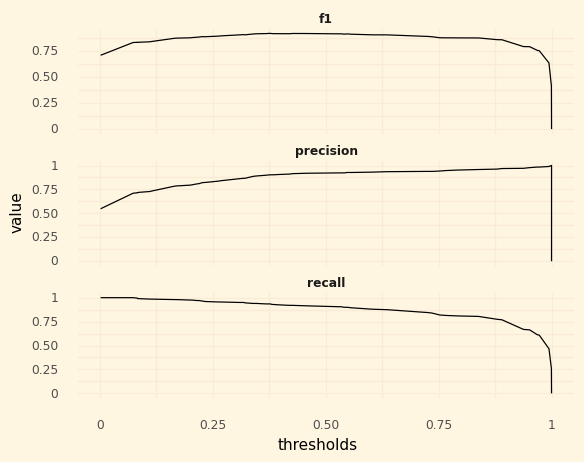

<ggplot: (194342674580)>

In [17]:
(
    pd.DataFrame(
        {
        "thresholds" : thresholds[1:],
        "f1" : [metrics.f1_score(y_test, (y_prob > x).astype(int)) for x in thresholds[1:]],
        "recall" : [metrics.recall_score(y_test, (y_prob > x).astype(int)) for x in thresholds[1:]],
        "precision" : [metrics.precision_score(y_test, (y_prob > x).astype(int)) for x in thresholds[1:]]
        }
    ) >>
    gather("metric", "value", -_.thresholds) >>
    filter(_.thresholds < 1) >>
    pn.ggplot(pn.aes("thresholds", "value")) + pn.geom_line() + pn.facet_wrap("~metric", ncol=1, scales="free_y") + \
        plot_fix()
)

In [18]:
df_unlabeled = (df >> filter(_.target < 0, ~_.Text.isna())).copy()

In [19]:
df_unlabeled["target_prob"] = gs_clf.predict_proba(df_unlabeled.Text)[:,1]
df_unlabeled["target"] = (df_unlabeled.target_prob > 0.98).astype(int)

In [20]:
df_unlabeled >> count(_.target)

,target,n
0,0,55387
1,1,341


In [21]:
(
    df_unlabeled >>
    filter(_.target == 1) >>
    select(_.Text)
).sample(10)

,Text
159913,"Nei, den skal ikke avsluttes."
205258,saken flatgrill
192407,"Denne saken er avsluttet, da det var beboers feil og skaden er reparert"
200665,Ny oppdatering. Vi har funnet en rimeligere løsning til denne saken og velger å avslutte saken hos dere. Uansett takk for støtten
209206,"Vi har ike bilnr som forvoldte skaden, kontakt Follo politikammer om saken."
183582,"Det står at saken er ferdigbehandlet, men det kan vel ikke stemme?"
4580,er ukjent med om dette er noe sameiet kan beslutte eller om seksjonseier selv kan bestemme?
199674,Kan denne saken vennligst slettes? Har opprettet en ny sak.
206814,Vi vil ikke sende inn noe krav om erstatning i denne saken. Kan avsluttes fra vår side.
156414,Denne saken løste seg selv uten behov for assistanse. -Frederick Kihle


In [22]:
df["regex_match_identifier"] = -1
df["regex_match"] = ""
for i, reg in enumerate(regexes):
    df.loc[df.tekst_orig.str.contains(reg, case=False, na=False), "regex_match_identifier"] = i


match_from_df = (
    df >>
    filter(_.regex_match_identifier >= 0) >>
    filter(_.Text.str.contains(regex_total, case=False, na=False)) >>
    select(_.Text, _.n_sentences, _.regex_match_identifier, _.message_hash, _.insurance_number, _.sequence_number, _.date_message)
)
match_from_df.drop_duplicates().to_excel("model_ikke_bruke_regex_results.xlsx", index=False)

In [23]:
df >> filter(_.regex_match_identifier >= 0) >> count(_.regex_match_identifier) >> arrange(_.n)

,regex_match_identifier,n
0,0,1
2,4,1
5,8,1
6,10,1
9,14,1
10,15,1
12,18,1
13,23,1
16,28,1
20,33,1


# analyse av resultater

In [24]:
dataframes = []
sheetnames = []
single_sentences = []

In [25]:
df = (
    df >>
    mutate(ikke_bruke = _.Text.str.contains(regex_total, case=False, na=False))
)

In [26]:
baserisk = (
    df >> 
    group_by(_.baserisk) >>
    summarize(
        n_ikke_bruke = _.ikke_bruke.sum(),
        antall_meldinger_totalt = _.ikke_bruke.size,
        prosent_statusmeld = _.ikke_bruke.sum()/_.ikke_bruke.size*100
    )
)

baserisk

,baserisk,n_ikke_bruke,antall_meldinger_totalt,prosent_statusmeld
0,1006,73,6284,1.162
1,2001,13,4500,0.289
2,2004,56,4985,1.123
3,4002,272,27389,0.993
4,4003,68,5700,1.193
5,4010,121,7973,1.518


In [27]:
dataframes.append(baserisk)
sheetnames.append("antall per baserisk")

In [28]:
n_ikke_bruke = df.ikke_bruke.sum()
n_manuelt_markert = (df >> filter(_.label == "Lukk saken")).shape[0]
n_manuelle_jeg_finner = (df >> filter(_.label == "Lukk saken", _.ikke_bruke == 1)).shape[0]

In [29]:
single_sentences.append(f"finner {n_ikke_bruke} meldinger om å lukke saken")
single_sentences.append(f"Det er {n_manuelt_markert} meldinger manuelt markert som 'lukk saken'")
single_sentences.append(f"Regexene finner {n_manuelle_jeg_finner} av de manuelt markerte. finne-prosent (recall) = {n_manuelle_jeg_finner/n_manuelt_markert}")

In [30]:
single_sentences

['finner 603 meldinger om å lukke saken',
 "Det er 76 meldinger manuelt markert som 'lukk saken'",
 'Regexene finner 74 av de manuelt markerte. finne-prosent (recall) = 0.9736842105263158']

In [31]:
dataframes.append(pd.DataFrame({"div": single_sentences}))
sheetnames.append("div")

with pd.ExcelWriter("ikkebruke_results_kaja.xlsx") as writer:
    for df_tmp, name in zip(dataframes, sheetnames):
        df_tmp.to_excel(writer, sheet_name=name, index=False)